In [1]:
import pandas as pd
import numpy as np
from numpy.random import randint, choice, normal,shuffle
from scipy.special import factorial
from sklearn.model_selection import learning_curve, TimeSeriesSplit, PredefinedSplit
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
%matplotlib inline
plt.style.use('fivethirtyeight')
plt.rc('figure', figsize=(14, 8))

## Generate Sample Data

In [3]:
max_degree = 10
def f(x):
    taylor = [(-1)**i * x ** e / factorial(e) for i, e in enumerate(range(1, max_degree, 2))]
    return  np.sum(taylor, axis=0)

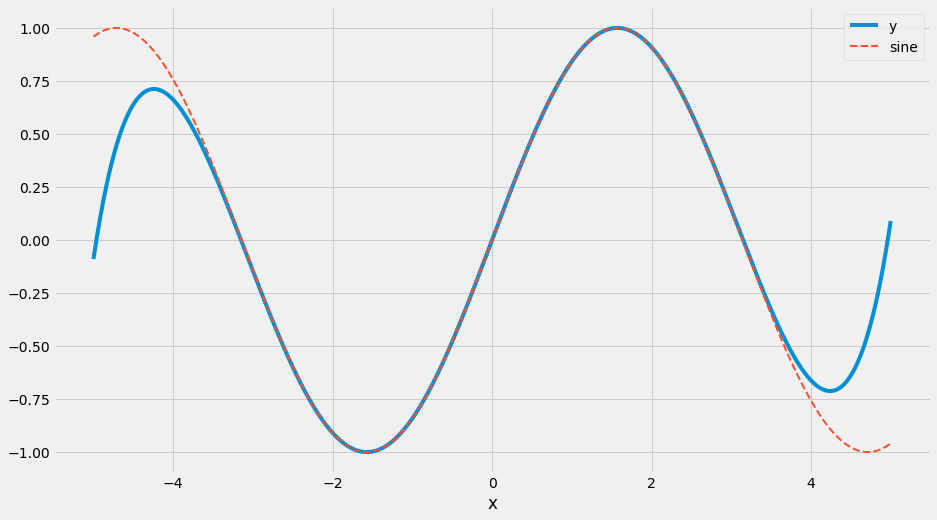

In [4]:
x = np.linspace(-5, 5, 1000)
data = pd.DataFrame({'y': f(x), 'x': x})
ax = data.plot(x='x', y='y', legend=False)
pd.Series(np.sin(x), index=x).plot(ax=ax, ls='--', lw=2, label='sine')
plt.legend();

### Train Model

In [5]:
X={}
datasets = ['Train', 'Test']
X['Train'] = np.linspace(-3, 3, 2500)
X['Test'] = np.linspace(3, 5, 500)
models = {'Underfit': 3, 'Right Fit': 9, 'Overfit': 15}

sample, noise = 100, .2
result = pd.DataFrame()
for i in range(100):
    x_ = {d: choice(X[d], size=sample, replace=False) for d in datasets}
    y_ = {d: f(x_[d]) for d in datasets}
    y_['Train'] += normal(loc=0,
                          scale=np.std(y_['Train']) * noise,
                          size=sample)

    trained_models = {fit: np.poly1d(np.polyfit(x=x_['Train'],
                                        y=y_['Train'],
                                        deg=deg))
              for fit, deg in models.items()}

    for fit, model in trained_models.items():
        for dataset in datasets:
            pred = model(x_[dataset])
            result = result.append(pd.DataFrame(dict(x=x_[dataset],
                                                     Model=fit,
                                                     Data=dataset,
                                                     y=pred,
                                                     Error=pred - y_[dataset])))

In [6]:
y = {d: f(X[d]) for d in datasets}
y['Train_noise'] = y['Train'] + normal(loc=0,
                                       scale=np.std(y['Train']) * noise,
                                       size=len(y['Train']))
colors = {'Underfit': 'darkblue', 'Right Fit': 'darkgreen', 'Overfit': 'darkred'}
test_data = result[result.Data == 'Test']

### Plot result

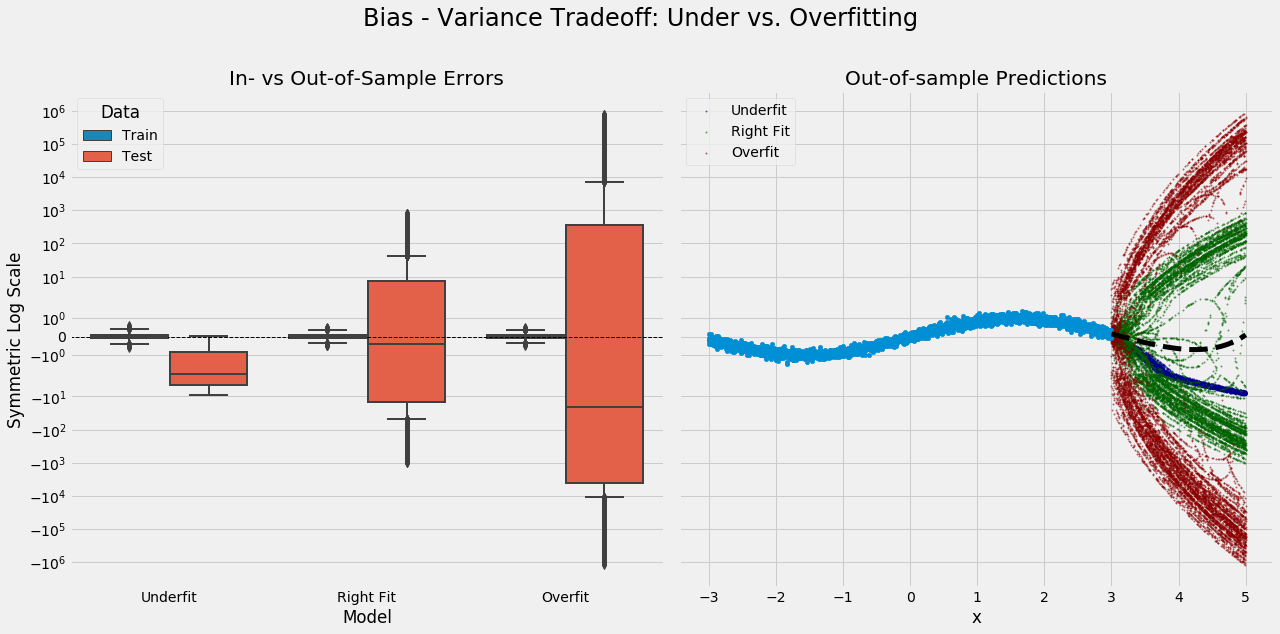

In [7]:
fig, axes = plt.subplots(ncols=2, figsize=(18, 9), sharey=True)
sns.boxplot(x='Model', y='Error', hue='Data',
            data=result, ax=axes[0], linewidth=2)
axes[0].set_title('In- vs Out-of-Sample Errors')
axes[0].axhline(0, ls='--', lw=1, color='k')
axes[0].set_ylabel('Symmetric Log Scale')

for model in colors.keys():
    (test_data[(test_data['Model'] == model)]
     .plot.scatter(x='x',
                   y='y',
                   ax=axes[1],
                   s=2,
                   color=colors[model],
                   alpha=.5,
                   label=model))

pd.Series(y['Train'], index=X['Train']).sort_index().plot(
    ax=axes[1], title='Out-of-sample Predictions')
pd.DataFrame(dict(x=X['Train'], y=y['Train_noise'])
             ).plot.scatter(x='x', y='y', ax=axes[1])
pd.Series(y['Test'], index=X['Test']).plot(
    color='black', lw=5, ls='--', ax=axes[1], label='Actuals')
plt.yscale('symlog')

fig.tight_layout()
fig.suptitle('Bias - Variance Tradeoff: Under vs. Overfitting', fontsize=24)
fig.savefig('bias_variance', dpi=600)
fig.subplots_adjust(top=0.85)

In [8]:
def folds(train, test, nfolds):
    shuffle(train)
    shuffle(test)
    
    steps = (np.array([len(train), len(test)]) / nfolds).astype(int)
    for fold in range(nfolds):
        i, j = fold * steps
        yield train[i:i + steps[0]], test[j: j+steps[1]]

In [9]:
def rmse(y, x, model):
    return np.sqrt(mean_squared_error(y_true=y, y_pred=model.predict(x)))

In [10]:
def create_poly_data(data, degree):
    return np.hstack((data.reshape(-1, 1) ** i) for i in range(degree + 1))

In [11]:
train_set = X['Train'] + normal(scale=np.std(f(X['Train']))) * .2
test_set =  X['Test'].copy()  

sample_sizes = np.arange(.1, 1.0, .01)
indices = ([len(train_set), len(test_set)] *
           sample_sizes.reshape(-1, 1)).astype(int)
result = []
lr = LinearRegression()
for label, degree in models.items():
    model_train = create_poly_data(train_set, degree)
    model_test = create_poly_data(test_set, degree)
    for train_idx, test_idx in indices:
        train = model_train[:train_idx]
        test = model_test[:test_idx]
        train_rmse, test_rmse = [], []
        for x_train, x_test in folds(train, test, 5):
            y_train, y_test = f(x_train[:, 1]), f(x_test[:, 1])
            lr.fit(X=x_train, y=y_train)
            train_rmse.append(rmse(y=y_train, x=x_train, model=lr))
            test_rmse.append(rmse(y=y_test, x=x_test, model=lr))
        result.append([label, train_idx,
                       np.mean(train_rmse), np.std(train_rmse),
                       np.mean(test_rmse), np.std(test_rmse)])

result = (pd.DataFrame(result,
                       columns=['Model', 'Train Size',
                                'Train RMSE', 'Train RMSE STD',
                                'Test RMSE', 'Test RMSE STD'])
          .set_index(['Model', 'Train Size']))

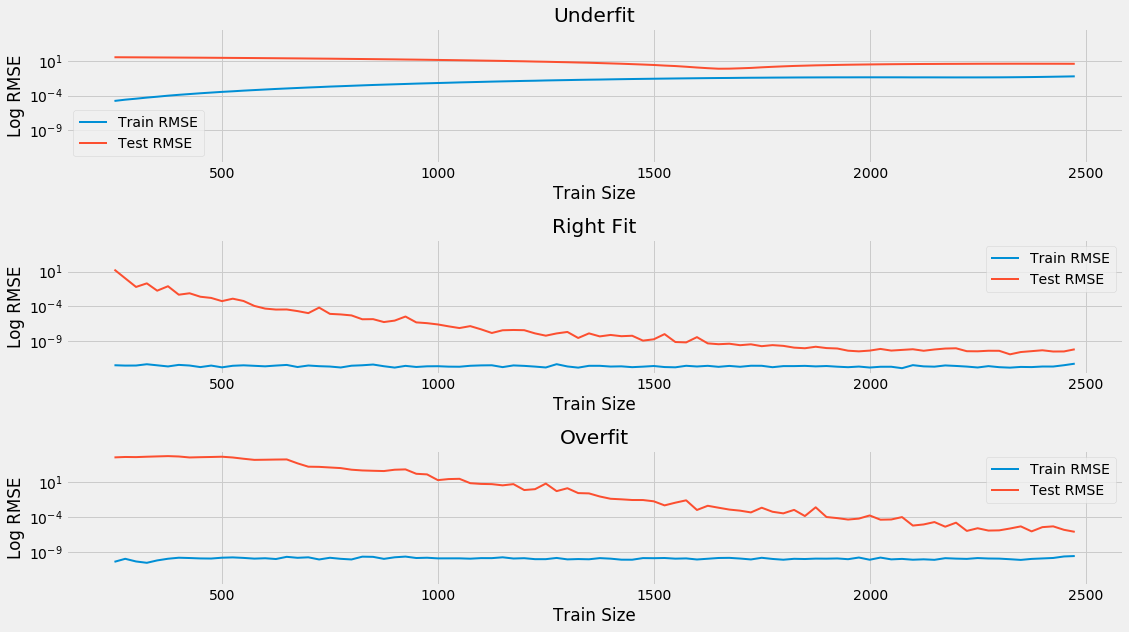

In [12]:
fig, axes = plt.subplots(nrows=3, sharey=True, figsize=(16, 9))
for i, model in enumerate(models.keys()):
    result.loc[model, ['Train RMSE', 'Test RMSE']].plot(ax=axes[i], title=model, logy=True, lw=2)
    axes[i].set_ylabel('Log RMSE')
plt.tight_layout();

In [13]:
train_set = X['Train'] + normal(scale=np.std(f(X['Train']))) * .2
test_set = X['Test'].copy()

sample_sizes = np.arange(.1, 1.0, .01)
indices = ([len(train_set), len(test_set)] *
           sample_sizes.reshape(-1, 1)).astype(int)
result = pd.DataFrame()
lr = LinearRegression()
for label, degree in models.items():
    model_train = create_poly_data(train_set, degree)
    model_test = create_poly_data(test_set, degree)
    for train_idx, test_idx in indices:
        train = model_train[:train_idx]
        test = model_test[:test_idx]
        train_rmse, test_rmse = [], []
        for x_train, x_test in folds(train, test, 10):
            y_train, y_test = f(x_train[:, 1]), f(x_test[:, 1])
            lr.fit(X=x_train, y=y_train)
            train_rmse.append(rmse(y=y_train, x=x_train, model=lr))
            test_rmse.append(rmse(y=y_test, x=x_test, model=lr))
        result = (result
                  .append(pd.DataFrame({'Model': label,
                                        'Train Size': train_idx,
                                        'Data': 'Train',
                                        'RMSE': train_rmse}))
                  .append(pd.DataFrame({'Model': label,
                                        'Train Size': train_idx,
                                        'Data': 'Test',
                                        'RMSE': test_rmse})))

/home/stefan/.pyenv/versions/at-3.6/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


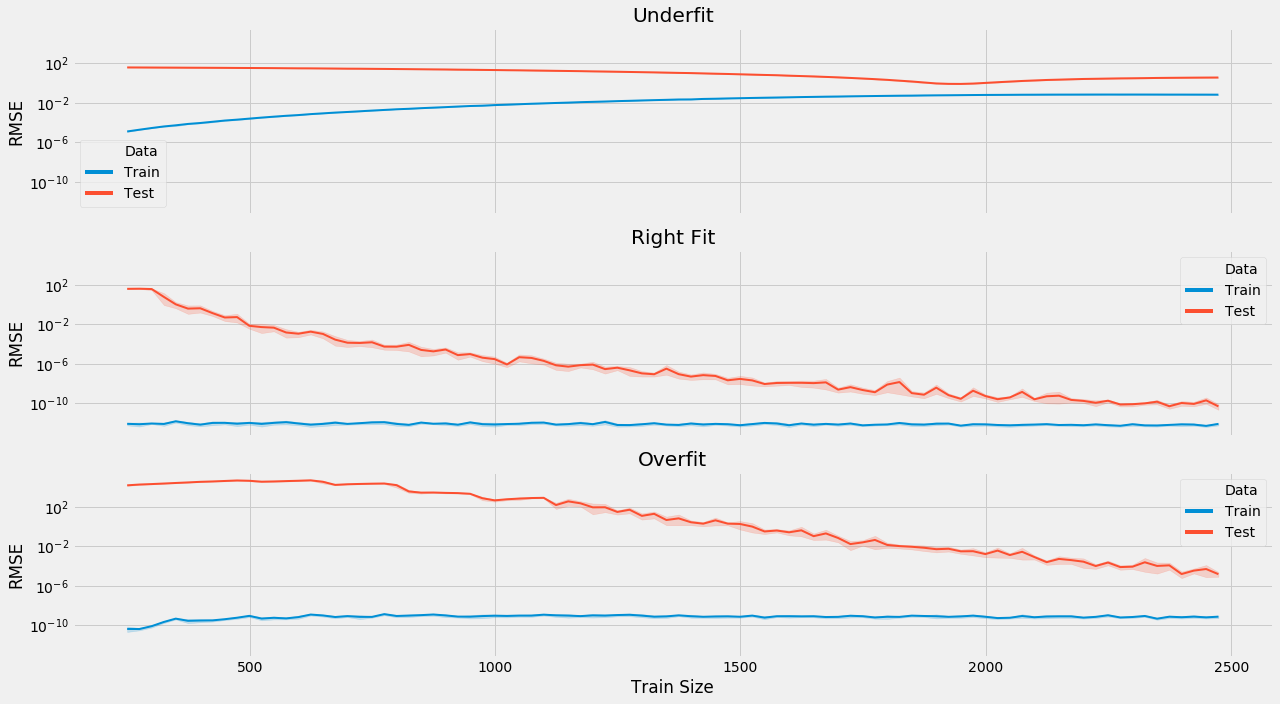

In [14]:
fig, axes = plt.subplots(nrows=3, sharey=True, sharex=True, figsize=(18, 10))
for i, model in enumerate(models.keys()):
    sns.lineplot(x='Train Size', y='RMSE', hue='Data', data=result[result.Model==model], ax=axes[i], lw=2)
    axes[i].set_title(model)
plt.yscale('log')
plt.tight_layout();